In [ ]:
!pip install transformers

In [ ]:
import os
import re
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from transformers import BertTokenizer
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
from sklearn.model_selection import train_test_split
import torch, torchvision
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn as nn
from transformers import BertModel
import random
import time

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!nvidia-smi

Wed Jul 28 08:25:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
!python --version

Python 3.7.10


In [ ]:
#!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.2 MB/s eta 0:16:18tcmalloc: large alloc 1147494400 bytes == 0x561faadf2000 @  0x7f76ea512615 0x561f725cf02c 0x561f726af17a 0x561f725d1e4d 0x561f726c3c0d 0x561f726460d8 0x561f72640c35 0x561f725d373a 0x561f72645f40 0x561f72640c35 0x561f725d373a 0x561f7264293b 0x561f726c4a56 0x561f72641fb3 0x561f726c4a56 0x561f72641fb3 0x561f726c4a56 0x561f72641fb3 0x561f725d3b99 0x561f72616e79 0x561f725d27b2 0x561f72645e65 0x561f72640c35 0x561f725d373a 0x561f7264293b 0x561f72640c35 0x561f725d373a 0x561f72641b0e 0x561f725d365a 0x561f72641d67 0x561f72640c35
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:39tcmalloc: large alloc 1434370048 bytes == 0x561fef448000 @  0x7f76ea512615 0x561f725cf02c 0x561f726af17a 0x561f725d1e4d 0x561f726c3c0d 0x561f726460d8 0x561f72640c35 0x561f725d373a 0x561f72645f40 0x561f72640c35 0x561f725d373a 0x561f7264293b 0x561f726c4a56 0x561f72641f

In [ ]:

print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.9.0+cu111 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
torch.cuda.is_available()

True

In [ ]:
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/mycolab/ob')
data_pos = pd.read_csv('/content/drive/My Drive/mycolab/ob/positive_news_dataset.csv')
data_pos['label'] = 1
#data_pos = data_pos[:-3000]
data_pos1 = pd.read_csv('/content/drive/My Drive/mycolab/ob/good_news_network_dataset.csv')
data_pos1['label'] = 1
data_neg = pd.read_csv('/content/drive/My Drive/mycolab/ob/crime_online_dataset.csv')
data_neg['label'] = 0
#data_neg = data_neg[:-3000]
data_set1=pd.read_csv('/content/drive/My Drive/mycolab/ob/trainset1.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_1 = pd.concat([data_pos, data_neg,data_pos1], axis=0).reset_index(drop=True)
data_1.drop(['sentiment'], inplace=True, axis=1)
data = pd.concat([data_1, data_set1], axis=0).reset_index(drop=True)
data.drop(['url'], inplace=True, axis=1)

In [ ]:
data = data[-1000:]

In [ ]:
data.sample(5)

,text,label
18978,Their office hours are spent on simple wooden ...,1
10102,A Houston accused of murdering his estranged w...,0
18867,"The Occupy Wall Street movement, forever angry...",1
26461,Miami-Dade mayor says two more bodies have bee...,0
28555,"Pallister '50 years out of date,' professor sa...",1


In [ ]:
data.shape

(29951, 2)

In [ ]:

X = data.text.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [ ]:


data_pos_test = pd.read_csv('/content/drive/My Drive/mycolab/ob/positive_news_dataset.csv')
data_pos_test['label'] = 1
data_pos_test = data_pos_test[3100:3600]
data_neg_test = pd.read_csv('/content/drive/My Drive/mycolab/ob/crime_online_dataset.csv')
data_neg_test['label'] = 0
data_neg_test = data_neg_test[3100:3600]
data_test = pd.concat([data_pos_test, data_neg_test], axis=0).reset_index(drop=True)
data_test.drop(['url'], inplace=True, axis=1)
data_test.drop(['sentiment'], inplace=True, axis=1)

In [ ]:

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
def text_preprocessing(text):
    """
    Remove unnecessary symbols
    @param    text (str): a string to be processed.
    @return   text (str): the processed string.
    
    """

    text = re.sub(r'(@.*?)[\s]', ' ', text)


    text = re.sub(r'&amp;', '&', text)


    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
df = pd.read_csv('/content/drive/My Drive/mycolab/ob/testset.csv')

In [ ]:
from newspaper import Article
for num in range(0,df.shape[0]):
  print(num)
  df['text'].loc[num]=get_text(df['url'].loc[num])

0
1


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [ ]:
X_test = df.text.values
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)
probs = nb_model.predict_proba(X_test_tfidf)
probs.shape

KeyboardInterrupt: ignored

In [ ]:
probs = nb_model.predict_proba(X_test_tfidf)
probs.shape

(500, 2)

In [ ]:
probs[:,-1]
y_true = np.zeros(df.shape[0])
for num in range(0,df.shape[0]):
  if probs[:,-1][num]>0.5:
    y_true[num] = 1
y_true


array([0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0.

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
y_test1  = np.zeros(250)
y_test2 = np.ones(250)
y_test = np.concatenate((y_test1,y_test2),axis=0)
y_test.shape
accuracy = accuracy_score(y_test,y_true)
print(accuracy)
tn, fp, fn, tp = confusion_matrix(y_test,y_true).ravel()
[tn, fp, fn, tp]

0.732


[116, 134, 0, 250]

In [ ]:


# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  1.0


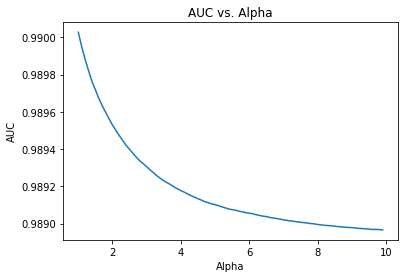

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc
def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text

X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

0


NameError: ignored

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)
evaluate_roc(probs, y_val)

AUC: 0.9894
Accuracy: 94.49%


In [ ]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  What’s the secret to happiness? This course at Yale University sets out to answer the question – and it has proved extremely popularA class titled Psychology and the Good Life at Yale University in the US is so popular that one in four undergraduate students have enrolled.Laurie Santos, the psychology professor who teaches on the course, says it is the most students ever to enrol in a class in the history of Yale, which was founded in 1701.Homework assignments include showing more gratitude, performing acts of kindness and improving social connections. The course also includes practical advice such as choosing satisfying careers, and separating satisfying pursuits from hollow ones.
Processed:  What’s the secret to happiness? This course at Yale University sets out to answer the question – and it has proved extremely popularA class titled Psychology and the Good Life at Yale University in the US is so popular that one in four undergraduate students have enrolled.Laurie Santos

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Pre-processing for BERT model
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """

    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add [CLS] and [SEP]
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,
            truncation=True# Return attention mask
            )
        

        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))


    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Concatenate train data and test data
all_texts = data.text.values

# Encode our concatenated data
encoded_texts = [tokenizer.encode(sent, add_special_tokens=True,max_length=512,truncation=True) for sent in all_texts]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_texts])
print('Max length: ', max_len)

KeyboardInterrupt: ignored

In [ ]:
num=0
for sent in encoded_texts:
    if len(sent)==512:
        num=num+1
print(num)

7656


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', len(token_ids))

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  What’s the secret to happiness? This course at Yale University sets out to answer the question – and it has proved extremely popularA class titled Psychology and the Good Life at Yale University in the US is so popular that one in four undergraduate students have enrolled.Laurie Santos, the psychology professor who teaches on the course, says it is the most students ever to enrol in a class in the history of Yale, which was founded in 1701.Homework assignments include showing more gratitude, performing acts of kindness and improving social connections. The course also includes practical advice such as choosing satisfying careers, and separating satisfying pursuits from hollow ones.
Token IDs:  512
Tokenizing data...


In [ ]:
MAX_LEN = 512
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=2,lr=5e-5):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=lr,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:


# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2,lr=5e-5)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.403066   |     -      |     -     |   15.98  
   1    |   40    |   0.105622   |     -      |     -     |   15.12  
   1    |   60    |   0.035611   |     -      |     -     |   15.50  
   1    |   80    |   0.018572   |     -      |     -     |   16.07  
   1    |   100   |   0.137186   |     -      |     -     |   16.58  
   1    |   120   |   0.038355   |     -      |     -     |   17.13  
   1    |   140   |   0.003380   |     -      |     -     |   18.11  
   1    |   160   |   0.012644   |     -      |     -     |   18.12  
   1    |   180   |   0.001866   |     -      |     -     |   17.41  
   1    |   200   |   0.102330   |     -      |     -     |   17.22  
   1    |   220   |   0.040823   |     -      |     -     |   17.30  
   1    |   240   |   0.066972   |     -      |     -     |   17.66  


In [ ]:

with open('/content/drive/My Drive/mycolab/ob/lr_model1.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3,lr=5e-5)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

with open('/content/drive/My Drive/mycolab/ob/lr_model2.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.403109   |     -      |     -     |   16.72  
   1    |   40    |   0.105499   |     -      |     -     |   14.62  
   1    |   60    |   0.035844   |     -      |     -     |   14.80  
   1    |   80    |   0.018020   |     -      |     -     |   15.33  
   1    |   100   |   0.138348   |     -      |     -     |   15.57  
   1    |   120   |   0.038239   |     -      |     -     |   16.11  
   1    |   140   |   0.003223   |     -      |     -     |   16.64  
   1    |   160   |   0.107043   |     -      |     -     |   16.21  
   1    |   180   |   0.004141   |     -      |     -     |   15.91  
   1    |   200   |   0.085096   |     -      |     -     |   15.85  
   1    |   220   |   0.002214   |     -      |     -     |   15.86  
   1    |   240   |   0.104193   |     -      |     -     |   16.00  


NameError: ignored

In [ ]:
import pickle
with open('/content/drive/My Drive/mycolab/ob/lr_model2.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4,lr=5e-5)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

with open('/content/drive/My Drive/mycolab/ob/lr_model3.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.341009   |     -      |     -     |   10.23  
   1    |   40    |   0.035067   |     -      |     -     |   9.47   
   1    |   60    |   0.076399   |     -      |     -     |   9.49   
   1    |   80    |   0.050432   |     -      |     -     |   9.51   
   1    |   100   |   0.050829   |     -      |     -     |   9.50   
   1    |   120   |   0.055280   |     -      |     -     |   9.50   
   1    |   140   |   0.083510   |     -      |     -     |   9.52   
   1    |   160   |   0.056794   |     -      |     -     |   9.50   
   1    |   180   |   0.043393   |     -      |     -     |   9.52   
   1    |   200   |   0.024454   |     -      |     -     |   9.52   
   1    |   220   |   0.017199   |     -      |     -     |   9.51   
   1    |   240   |   0.075596   |     -      |     -     |   9.53   


In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2,lr=2e-6)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

with open('/content/drive/My Drive/mycolab/ob/lr_model4.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.676478   |     -      |     -     |   17.96  
   1    |   40    |   0.640667   |     -      |     -     |   16.98  
   1    |   60    |   0.576343   |     -      |     -     |   16.96  
   1    |   80    |   0.501619   |     -      |     -     |   16.97  
   1    |   100   |   0.406502   |     -      |     -     |   16.96  
   1    |   120   |   0.321839   |     -      |     -     |   16.96  
   1    |   140   |   0.256456   |     -      |     -     |   16.97  
   1    |   160   |   0.182960   |     -      |     -     |   16.95  
   1    |   180   |   0.159547   |     -      |     -     |   16.96  
   1    |   200   |   0.131660   |     -      |     -     |   16.97  
   1    |   220   |   0.098434   |     -      |     -     |   16.98  
   1    |   240   |   0.080929   |     -      |     -     |   16.94  


In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3,lr=5e-6)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

with open('/content/drive/My Drive/mycolab/ob/lr_model5.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2,lr=3e-6)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

with open('/content/drive/My Drive/mycolab/ob/lr_model6.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.670454   |     -      |     -     |   17.88  
   1    |   40    |   0.602665   |     -      |     -     |   16.92  
   1    |   60    |   0.491426   |     -      |     -     |   16.92  
   1    |   80    |   0.362424   |     -      |     -     |   16.91  
   1    |   100   |   0.250362   |     -      |     -     |   16.94  
   1    |   120   |   0.178239   |     -      |     -     |   16.92  
   1    |   140   |   0.147064   |     -      |     -     |   16.91  
   1    |   160   |   0.094126   |     -      |     -     |   16.92  
   1    |   180   |   0.084845   |     -      |     -     |   16.92  
   1    |   200   |   0.082623   |     -      |     -     |   16.94  
   1    |   220   |   0.053554   |     -      |     -     |   16.92  
   1    |   240   |   0.052630   |     -      |     -     |   16.90  


NameError: ignored

In [ ]:
import pickle
with open('/content/drive/My Drive/mycolab/ob/lr_model.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

NameError: ignored

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3,lr=3e-6)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

with open('/content/drive/My Drive/mycolab/ob/lr_model7.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

In [ ]:
with open('lr_model.pickle', 'rb') as fp:
    bert_model = pickle.load(fp)

FileNotFoundError: ignored

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
data_test.sample(5)

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(data_test.text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=2)

In [ ]:
data_pos_test = pd.read_csv('dataset/positive_news_dataset.csv')
data_pos_test['label'] = 1
data_pos_test = data_pos_test[3100:3600]
data_neg_test = pd.read_csv('dataset/crime_online_dataset.csv')
data_neg_test['label'] = 0
data_neg_test = data_neg_test[3100:3600]
data_test = pd.concat([data_pos_test, data_neg_test], axis=0).reset_index(drop=True)
data_test.drop(['url'], inplace=True, axis=1)
data_test.drop(['sentiment'], inplace=True, axis=1)
X_test = data_test.text.values
y_test = data_test.label.values
test_inputs, test_masks = preprocessing_for_bert(data_test.text)
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=2)

In [ ]:
y_test

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

In [ ]:
y_test

In [ ]:
data_pos_test = pd.read_csv('dataset/good_news_network_dataset.csv')
data_pos_test['label'] = 1
data_pos_test = data_pos_test[1000:1100]
data_neg_test = pd.read_csv('dataset/crime_online_dataset.csv')
data_neg_test['label'] = 0
data_neg_test = data_neg_test[5000:5100]
data_test = pd.concat([data_pos_test, data_neg_test], axis=0).reset_index(drop=True)
data_test.drop(['url'], inplace=True, axis=1)
data_test.drop(['sentiment'], inplace=True, axis=1)
data_test = data_test[0:100]
X_test = data_test.text.values
y_test = data_test.label.values
test_inputs, test_masks = preprocessing_for_bert(data_test.text)
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=2)

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

In [ ]:
data_test.shape

In [ ]:
data_pos_test = pd.read_csv('dataset/good_news_network_dataset.csv')
data_pos_test['label'] = 1
data_pos_test = data_pos_test[900:1000]
data_neg_test = pd.read_csv('dataset/crime_online_dataset.csv')
data_neg_test['label'] = 0
data_neg_test = data_neg_test[6000:6100]
data_test = pd.concat([data_pos_test, data_neg_test], axis=0).reset_index(drop=True)
data_test.drop(['url'], inplace=True, axis=1)
data_test.drop(['sentiment'], inplace=True, axis=1)
data_test = data_test[0:100]
X_test = data_test.text.values
y_test = data_test.label.values
test_inputs, test_masks = preprocessing_for_bert(data_test.text)
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=2)

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

In [ ]:
preds = probs[:, 1]
y_pred = np.where(preds >= 0.5, 1, 0)

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
!pip install newspaper3k

     |████████████████████████████████| 211 kB 7.6 MB/s 
     |████████████████████████████████| 87 kB 6.6 MB/s 
     |████████████████████████████████| 7.4 MB 23.9 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=27c5282de63140c0bed0417583231abd67e3e55021eef8b017488ab9492955b2
  Stored in directory: /root/.cache/pip/wheels/df/67/41/faca10fa501ca010be41b49d40360c2959e1c4f09bcbfa37fa
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3356 sha256=3c559c940a5a0b598dc2c5cb1c17fa5479bcd8bcd7864e0fdba335cb2585d203
  Stored in directory: /root/.cache/pip/wheels/7f/d4/8f/6e2ca54744c9d7292d88ddb8d42876bcdab5e6d84a21c10346
  Created wheel for jieba3k: filename=jieba3k-0.35.1-py3-none-any.whl size=7398405 sha256=2d8caae95e8b79663e6f81b73cee404de32bd1f7eafeabd42117076543581850
  Stored in directory: /root/.cache/pip/wheels/4c/91/46/3c208287b726df325a59795743

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import json
import requests
import pandas as pd
from newspaper import Config
from newspaper import Article
from newspaper.utils import BeautifulSoup

In [ ]:
from newspaper import Article
# 目标新闻网址
url = 'https://www.cbc.ca/news/canada/saskatchewan/child-welfare-cowessess-trudeau-moe-1.6090835'
news = Article(url)
news.download()        # 加载网页
news.parse()           # 解析网页
text = news.text
text

"WARNING: This story contains details some readers may find distressing.\n\nPrime Minister Justin Trudeau and Saskatchewan Premier Scott Moe are set to sign an agreement that will see Cowessess First Nation retake jurisdiction of child welfare, according to Chief Cadmus Delorme.\n\nThe agreement will be signed at the First Nation in a ceremony on Tuesday, Delorme said.\n\nCowessess has not had decision-making power over children in care since it was stripped of it in 1951, according to a letter distributed by Delorme on Monday.\n\nMore than 80 per cent of children in care in Saskatchewan are Indigenous, according to a 2018 children's advocate report.\n\nThat began to change with 2019's passage of An Act Respecting First Nations, Inuit and Métis Children, Youth and Families, aimed at reducing the number of youth in care and allowing communities to create their own child-welfare systems.\n\nCowessess did that in 2020, when it asserted its inherent rights over its children and families.\n

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
url = 'https://abcnews.go.com/International/wireStory/uk-joint-airdrop-drill-affirms-uks-support-jordan-78518143'
article = requests.get(url)
soup = bs(article.content, "html.parser")
text = ''
for EachPart in soup.select('div[class*="RichTextContainer"]'):
  for p in EachPart.find_all("p"):
    text = text+' '+p.text
text

''

In [ ]:
import pickle
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/mycolab/ob')
with open('/content/drive/My Drive/mycolab/ob/lr_model1.pickle', 'rb') as fp:
  bert_model = pickle.load(fp)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url = 'https://www.bbc.co.uk/news/world-asia-57606847'
article = requests.get(url)
soup = bs(article.content, "html.parser")
text = ''
for EachPart in soup.select('div[class*="RichTextContainer"]'):
  for p in EachPart.find_all("p"):
    text = text+' '+p.text
text

' For much of the past two centuries, it was illegal to be gay in a vast swathe of the world - thanks to colonial Britain. Till today, colonial-era laws that ban homosexuality continue to exist in former British territories including parts of Africa and Oceania. But it is in Asia where they have had a significantly widespread impact. This is the region where, before India legalised homosexual sex in 2018, at least one billion people lived with anti-LGBTQ legislation. It can be traced back to one particular law first conceptualised in India, and one man\'s mission to "modernise" the colony. Currently, it is illegal to be gay in around 69 countries, nearly two-thirds of which were under some form of British control at one point of time. This is no coincidence, according to Enze Han and Joseph O\'Mahoney, who wrote the book British Colonialism and the Criminalization of Homosexuality. Dr Han told the BBC that British rulers introduced such laws because of a "Victorian, Christian puritanic

In [ ]:
data = []
data.append(text)
a= np.array(data)
data_to_test = pd.Series(a)
test_inputs, test_masks = preprocessing_for_bert(data_to_test)
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=2)
prob = bert_predict(bert_model, test_dataloader)
prob[0,1]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.9979831

In [ ]:
def get_text(url):
    news = Article(url)
    news.download()
    news.parse()
    title = news.title
    if url.startswith('https://www.bbc'):
        article = requests.get(url)
        soup = bs(article.content, "html.parser")
        text = ''
        for EachPart in soup.select('div[class*="RichTextContainer"]'):
            for p in EachPart.find_all("p"):
                text = text+' '+p.text
        if len(text)==0:
            text=news.text
    else :
        text = news.text
    text = title+text
    return text

def predict(url):
  text=get_text(url)
  data=[]
  data.append(text)
  a= np.array(data)
  data_to_test = pd.Series(a)
  test_inputs, test_masks = preprocessing_for_bert(data_to_test)
  test_dataset = TensorDataset(test_inputs, test_masks)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=2)
  prob = bert_predict(bert_model, test_dataloader)
  return prob[0,1]



In [ ]:
import csv
with open("/content/drive/My Drive/mycolab/ob/testset.csv", "r", encoding = "utf-8") as f:
    reader = csv.reader(f)
    column = [row[2] for row in reader]

In [ ]:
import pickle
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/mycolab/ob')
with open('/content/drive/My Drive/mycolab/ob/bert_model1.pickle', 'rb') as fp:
  bert_model = pickle.load(fp)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def predicttext(text):
  data=[]
  data.append(text)
  a= np.array(data)
  data_to_test = pd.Series(a)
  test_inputs, test_masks = preprocessing_for_bert(data_to_test)
  test_dataset = TensorDataset(test_inputs, test_masks)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=2)
  prob = bert_predict(bert_model, test_dataloader)
  return prob[0,1]

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
MAX_LEN=512
df = pd.read_csv('/content/drive/My Drive/mycolab/ob/trainset1.csv')
for num in range(0,df.shape[0]):
  print(num)
  if predicttext(df['text'].loc[num])<0.5:
    df['sentiment'].loc[num]=0
df.to_csv('/content/drive/My Drive/mycolab/ob/trainset1.csv',index=False)

0
1
2
3


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


流式输出内容被截断，只能显示最后 5000 行内容。
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
166

In [ ]:
texts=[]

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
MAX_LEN=512
df = pd.read_csv('/content/drive/My Drive/mycolab/ob/testset.csv')
count = 0
y_true = np.zeros(df.shape[0])
a=0.55
b=1-a
for num in range(0,df.shape[0]):
  print(num)
  text = get_text(df['url'].loc[num])
  texts.append(text)
  if len(text)<=510:
    score = predicttext(text)
  elif len(text)>510:
    text1=text[0:510]
    text2=text[510:]
    score1 = predicttext(text1)
    score2 = predicttext(text2)
    score = a*score1+b*score2
  if score>0.5:
    y_true[num] = 1
y_true


0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
MAX_LEN=512
df = pd.read_csv('/content/drive/My Drive/mycolab/ob/testset.csv')
count = 0
y_true = np.zeros(df.shape[0])
a=0.9
b=1-a
for num in range(0,df.shape[0]):
  print(num)
  text = texts[num]
  textlist=text.split(" ")
  if len(textlist)<=510:
    text = " ".join(textlist)
    score = predicttext(text)
  elif len(textlist)>510:
    textlist1=textlist[0:510]
    textlist2=textlist[510:]
    text1 = " ".join(textlist1)
    text2 = " ".join(textlist2)
    score1 = predicttext(text1)
    score2 = predicttext(text2)
    score = a*score1+b*score2
  if score>0.9:
    y_true[num] = 1
y_true

0
1
2
3


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0.

In [ ]:
y_test1  = np.zeros(250)
y_test2 = np.ones(250)
y_test = np.concatenate((y_test1,y_test2),axis=0)
y_test.shape

(500,)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy = accuracy_score(y_test,y_true)
print(accuracy)
tn, fp, fn, tp = confusion_matrix(y_test,y_true).ravel()
[tn, fp, fn, tp]

0.838


[191, 59, 22, 228]

In [ ]:
len(texts[0].split(" "))

302

In [ ]:

y_true.shape

(500,)

In [ ]:
y_test1  = np.zeros(250)
y_test2 = np.ones(250)
y_test = np.concatenate((y_test1,y_test2),axis=0)
y_test.shape

(500,)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
y_test1  = np.zeros(250)
y_test2 = np.ones(250)
y_test = np.concatenate((y_test1,y_test2),axis=0)
y_test.shape
accuracy = accuracy_score(y_test,y_true)
print(accuracy)
tn, fp, fn, tp = confusion_matrix(y_test,y_true).ravel()
[tn, fp, fn, tp]

In [ ]:
accuracy = accuracy_score(y_test,y_true)
print(accuracy)
tn, fp, fn, tp = confusion_matrix(y_test,y_true).ravel()
[tn, fp, fn, tp]

0.834


[184, 66, 17, 233]

In [ ]:
import pickle
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3,lr=3e-6)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

with open('/content/drive/My Drive/mycolab/ob/bert_model1.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.686129   |     -      |     -     |   9.49   
   1    |   40    |   0.641000   |     -      |     -     |   9.03   
   1    |   60    |   0.577771   |     -      |     -     |   9.03   
   1    |   80    |   0.490160   |     -      |     -     |   9.03   
   1    |   100   |   0.396287   |     -      |     -     |   9.03   
   1    |   120   |   0.336325   |     -      |     -     |   9.03   
   1    |   140   |   0.257129   |     -      |     -     |   9.03   
   1    |   160   |   0.233346   |     -      |     -     |   9.04   
   1    |   180   |   0.188133   |     -      |     -     |   9.01   
   1    |   200   |   0.196943   |     -      |     -     |   9.03   
   1    |   220   |   0.167022   |     -      |     -     |   9.02   
   1    |   240   |   0.103183   |     -      |     -     |   9.00   


In [ ]:
import pickle
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1,lr=3e-6)
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

with open('/content/drive/My Drive/mycolab/ob/bert_model1.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.679226   |     -      |     -     |   9.51   
   1    |   40    |   0.638924   |     -      |     -     |   9.03   
   1    |   60    |   0.566960   |     -      |     -     |   9.04   
   1    |   80    |   0.482859   |     -      |     -     |   9.03   
   1    |   100   |   0.409099   |     -      |     -     |   9.03   
   1    |   120   |   0.347565   |     -      |     -     |   9.04   
   1    |   140   |   0.264103   |     -      |     -     |   9.04   
   1    |   160   |   0.230039   |     -      |     -     |   9.04   
   1    |   180   |   0.153100   |     -      |     -     |   9.04   
   1    |   200   |   0.154950   |     -      |     -     |   9.03   
   1    |   220   |   0.138506   |     -      |     -     |   9.02   
   1    |   240   |   0.130855   |     -      |     -     |   9.03   


RuntimeError: ignored

In [ ]:
import pickle
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3 ,lr=3e-6)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

with open('/content/drive/My Drive/mycolab/ob/bert_model2.pickle', 'wb') as fp:
    pickle.dump(bert_classifier, fp)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.544578   |     -      |     -     |   9.50   
   1    |   40    |   0.426634   |     -      |     -     |   9.02   
   1    |   60    |   0.366638   |     -      |     -     |   9.02   
   1    |   80    |   0.327667   |     -      |     -     |   9.02   
   1    |   100   |   0.258088   |     -      |     -     |   9.12   
   1    |   112   |   0.224266   |     -      |     -     |   5.21   
----------------------------------------------------------------------
   1    |    -    |   0.369096   |  0.224830  |   82.69   |   52.74  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.189234   |     -      |     -     |   9.4